In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import network
import os
from PIL import Image
import cv2
from tqdm.notebook import tqdm, trange
plt.style.use('seaborn-v0_8-whitegrid')

## Ex. 1

In [3]:
patches = utils.load_dataset('natural_images/')

### 1.2

In [4]:
theta = np.ones((1,))
n_iter = int(150e3)
gamma = 1e-4
net = network.Visual_network(
    n_in = 16*16,
    n_out = 1,
)
untrained_weights = net.weights.copy()
utils.train_network(net, patches, n_iter, theta, gamma)

### 1.3

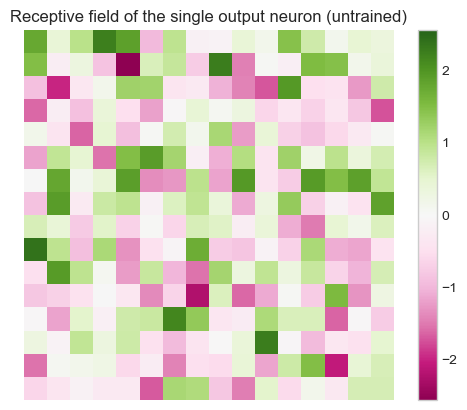

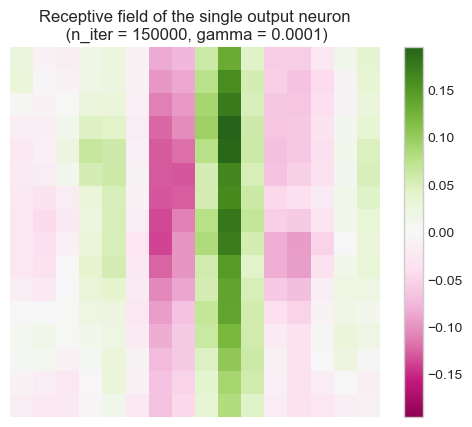

In [5]:
utils.show_RF(untrained_weights, 16, title="Receptive field of the single output neuron (untrained)")
utils.show_RF(net.weights, 16, title=f"Receptive field of the single output neuron\n (n_iter = {n_iter}, gamma = {gamma})")

#### Answer:
After learning, the RF is not anymore random but it exibits a very organised structure: we can clearly see a vertical stripe (because of strong positive weights, green in the pic) flanked by weaker negative weights (magenta). So the learned neuron behaves like a vertical-bar detector  that acts by contrast (excitation on the center, inhibition on the sides).

### 1.4

In [6]:
spiking_frequencies = []
for patch in patches:
    spiking_frequencies.append([
        net.forward(patch),
        net.forward(patch, untrained_weights),
    ])
spiking_frequencies = np.array(spiking_frequencies).squeeze(2)
spiking_difference = spiking_frequencies[:, 0] - spiking_frequencies[:, 1]

(-40.0, 40.0)

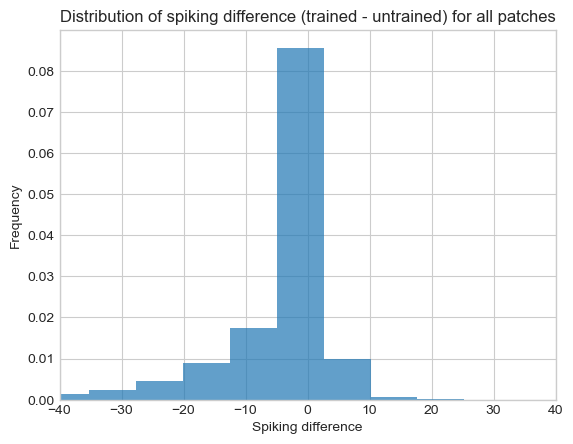

In [7]:
plt.hist(
    spiking_difference,
    bins=30,
    alpha=0.7,
    density=True,
)
plt.title('Distribution of spiking difference (trained - untrained) for all patches')
plt.xlabel('Spiking difference')
plt.ylabel('Frequency')
plt.xlim([-40, 40])

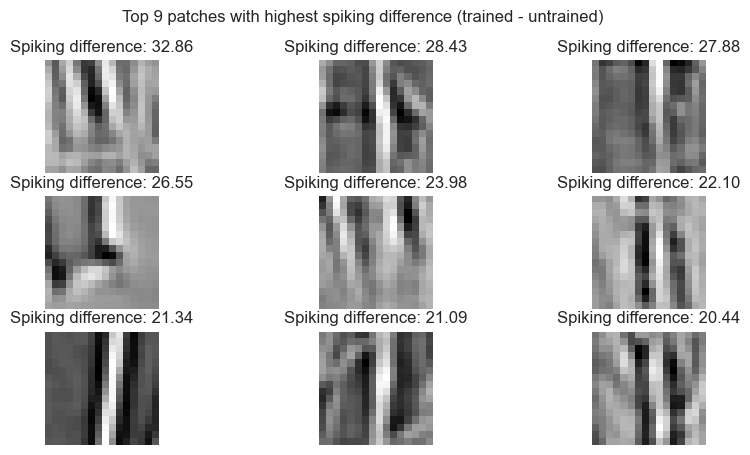

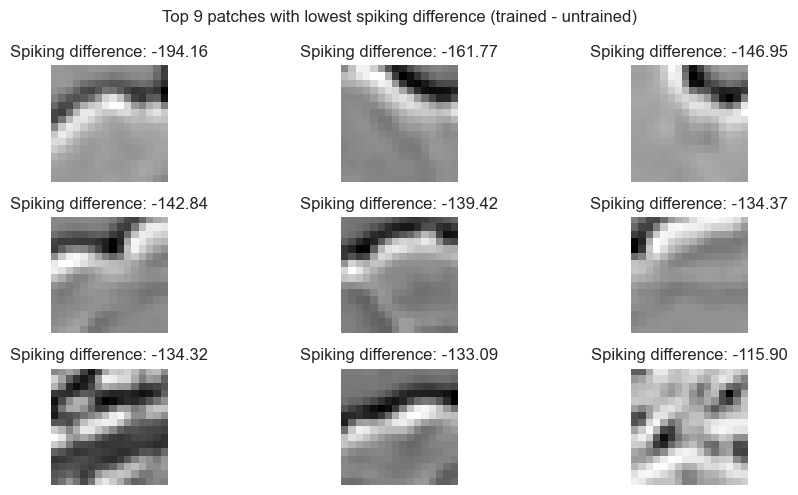

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(10, 5))
spiking_difference_sorted_indices = np.argsort(spiking_difference)[::-1]
for i, ax in enumerate(axs.flat):
    ax.imshow(patches[spiking_difference_sorted_indices[i]].reshape(16, 16), cmap='gray')
    ax.set_title(f'Spiking difference: {spiking_difference[spiking_difference_sorted_indices[i]]:.2f}')
    ax.axis('off')
plt.suptitle('Top 9 patches with highest spiking difference (trained - untrained)')

fig, axs = plt.subplots(3, 3, figsize=(10, 5))
spiking_difference_sorted_indices = spiking_difference_sorted_indices[::-1]
for i, ax in enumerate(axs.flat):
    ax.imshow(patches[spiking_difference_sorted_indices[i]].reshape(16, 16), cmap='gray')
    ax.set_title(f'Spiking difference: {spiking_difference[spiking_difference_sorted_indices[i]]:.2f}')
    ax.axis('off')
plt.suptitle('Top 9 patches with lowest spiking difference (trained - untrained)')
plt.tight_layout()
plt.show()

#### Answer:
According to what said for $1.3$ the neuron acts like a vertical-bar detector: it makes sense that the patches that show a marked verticality with the edges (as it happens with the first $9$ in picture) are the ones causing the strongest response/firing. The last $9$ patches, instead, are more horizontal and thus they do not activate the neuron as much.

### 1.5
#### Answer:
We can run a Monte-Carlo test:

* **Null $H_0$**: responses from the trained weights come from the same distribution as responses from random weights.  
* **Alt  $H_1$**: they come from a different distribution (stronger or anyway more selective).

We need to select one metric that sums up “response strength” and one simple choice can be represented by:
$$
\text{Average Rectified Response} := S(w) = \frac{1}{N}\sum_{n=1}^{N} net.forward(x_{n})  =\frac{1}{N} \sum_{n=1}^{N} \bigl [(w^{\!\top}x_{n})_{+}\bigr]
$$  
where `(·)₊` is ReLU and `{xₙ}` is a held-out image set.

- After making K random weights matrices with the same size and norm as the trained one (means we're only testing *structure*, not scale) we compute `S` for each of them and this will represent our *null* distribution.  
- We compute `S_train` for the real filter.  
- p-value = fraction of random scores ≥ `S_train`  
   (add $+1$ to numerator and denominator so it never hits $0$ exactly).  
$$
p = \frac{\#\{\,k \mid S_k \ge S_{\text{train}}\,\}\;+\;1}{K\;+\;1}
$$

- if $p < 0.05$ we can reject the null hypothesis $H_0$ with a confidence of $0.95$ and say the trained RF is significantly different.

### 1.6

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

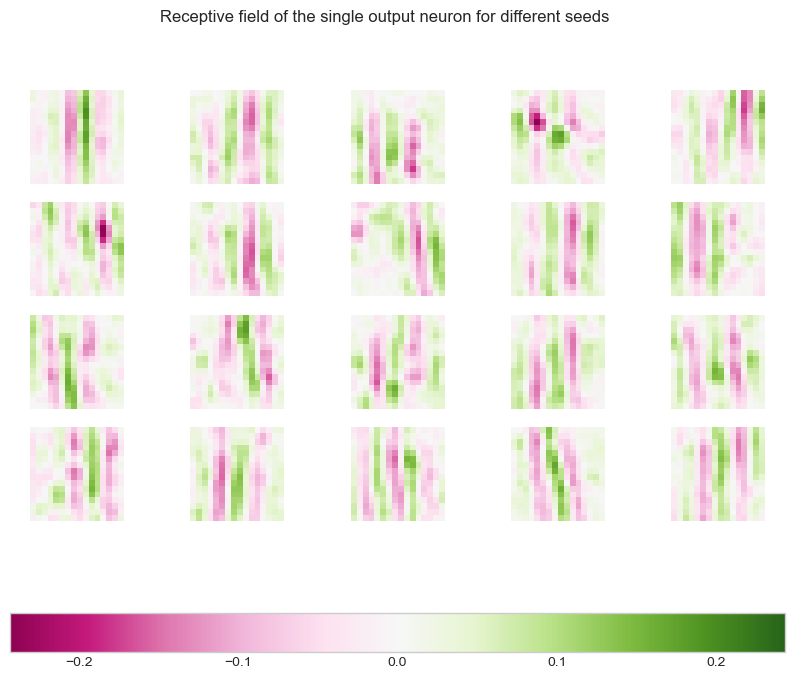

In [9]:
theta = np.ones((1,))
n_iter = int(150e3)
gamma = 1e-4
n_trials = 20
seeds = range(n_trials)
rfs = []
for seed in tqdm(seeds, desc="Training networks with different seeds"):
    net = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
    )
    utils.train_network(net, patches, n_iter, theta, gamma, seed)
    rfs.append(net.weights)
utils.show_RFs(rfs, n_col=5, patch_size=16, title="Receptive field of the single output neuron for different seeds")
    

#### Answer: 
* In the majority of runs the neuron develops a simple-cell-like contrast-sensitive RF: a clear vertical (or slightly tilted) bar of one sign flanked by regions of the opposite sign, indicative of a wider spatial frequency preference rather than a fundamentally different feature.
Nearly every RF is tuned to vertical or near-vertical edge; horizontal or diagonal selectivity is rare. This suggests a statistical bias and it most likely originates in the training images (vertical contours are plentiful in natural scenes with trees).
* Even the “noisiest” cases (two or three RFs look less "clean", containing blobs or curved streaks—evidence that the optimisation can settle in local minima when the initial weights are unlucky) show clustered positive and negative patches, indicating that learning consistently extracts some meaningful feature, so none of them resemble the noise pattern of an untrained RF.
* We can confidently say that changing the random seed mostly changes which vertical edge the neuron tunes to, not whether it becomes an edge detector.

### 1.7, 1.8

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

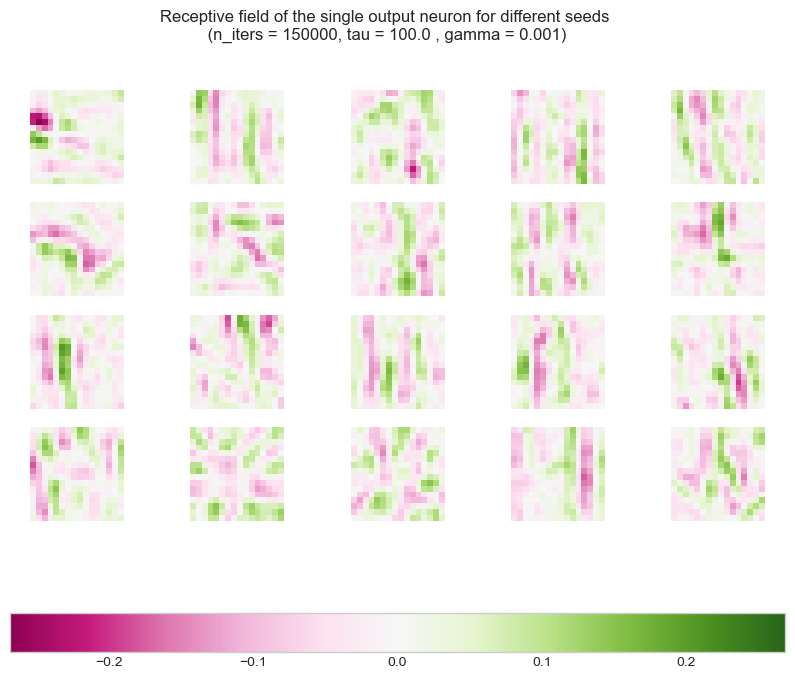

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

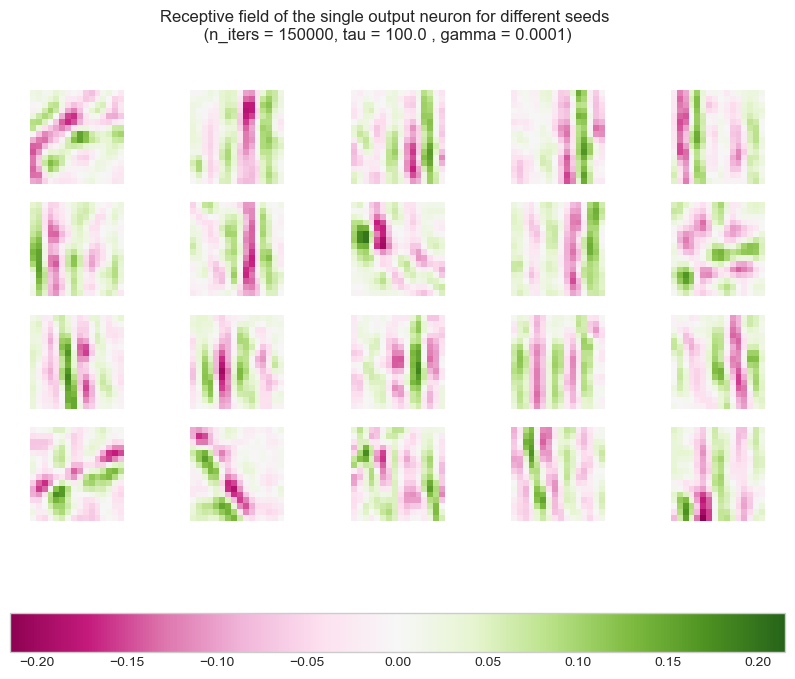

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

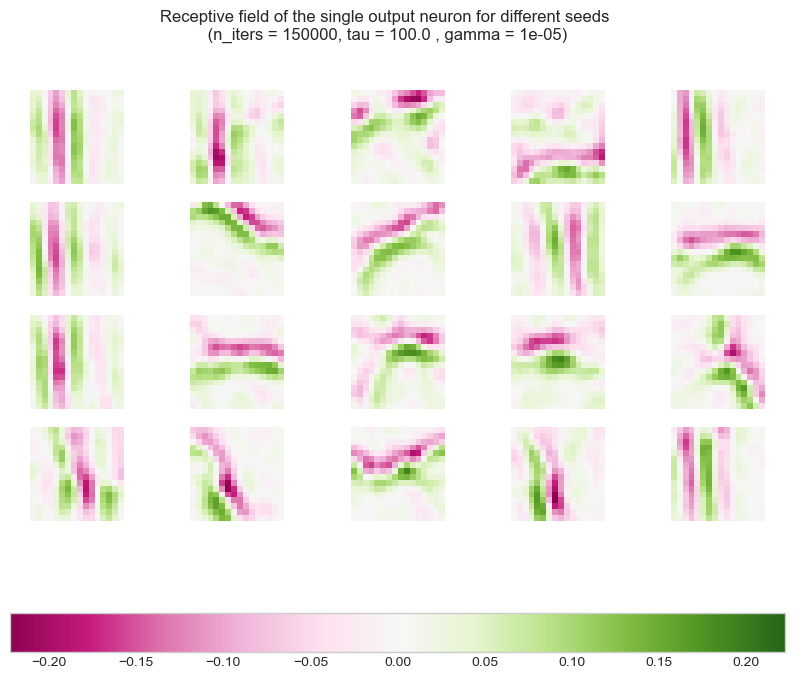

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

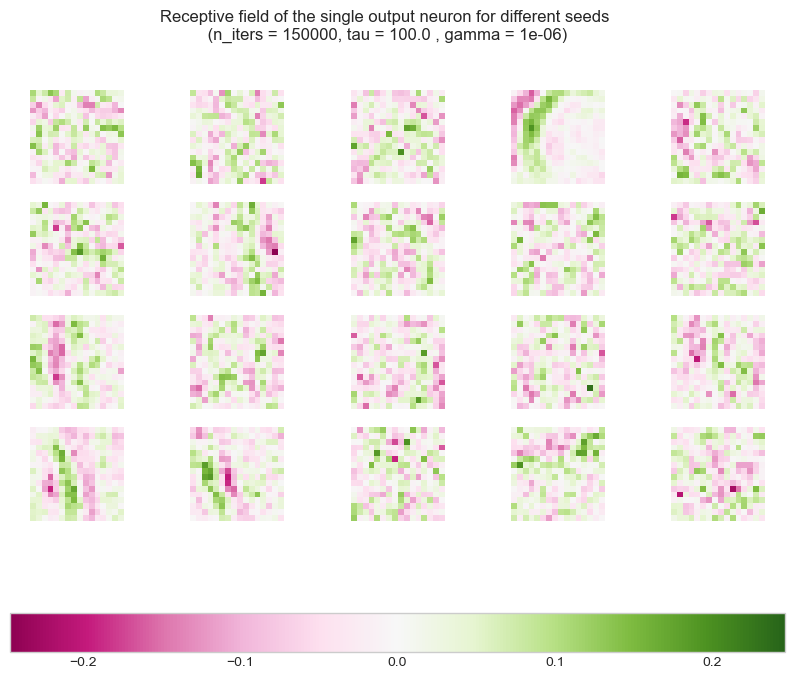

In [10]:
n_iter = int(150e3)
n_trials = 20
tau = 1e2
seeds = range(n_trials)
gammas = [1e-3, 1e-4, 1e-5, 1e-6]

for gamma in gammas:
    rfs = []
    for seed in tqdm(seeds, desc="Training networks with different seeds"):
        net = network.Visual_network(
            n_in = 16*16,
            n_out = 1,
            seed=seed,
        )
        theta = np.zeros((1,))
        utils.train_network(
            net=net,
            patches=patches,
            theta=theta,
            n_iter=n_iter,
            gamma=gamma,
            seed=seed,
            tau=tau,
        )
        rfs.append(net.weights)
    utils.show_RFs(rfs, n_col=5, patch_size=16, title=f"Receptive field of the single output neuron for different seeds\n (n_iters = {n_iter}, tau = {tau} , gamma = {gamma})")

#### Answer:
- In 1.6 (fixed $\theta$) almost every seed converged to a clean vertical bar.  With the sliding $\theta$ the collection is far more varied: we still get bars, but also diagonals, curves, even patchy / blob-like things.  Homeostasis pushes each seed to explore a different niche instead of all latching onto the same vertical edge.
- Increasing $\gamma$ past the sweet spot makes learning unstable and low-contrast: sometimes it explodes so the weights overshoot and $\theta$ adapts too slowly to stabilise them.

- Decreasing $\gamma$ makes learning so slow that the neuron never carves out a clear edge.

- With the adaptive $\theta$ in place, an intermediate $\gamma$ (around $10^{-5}$ – $10^{-4}$ in this setup) produces the richest and most stable variety of receptive fields.


### 1.9

#### Answer:

$\theta$ is the neuron's own activity set-point. 
It rises if the cell keeps firing a lot, drops if the cell is mostly quiet.

When $\theta$ is fixed every neuron shares the same target. Once an easy-to-find feature (like a vertical edge is in the case at hand) pushes it over that fixed line, learning stops changing much. As a result many seeds converge to similar RFs.

When $\theta$ is adaptive the neuron drags its threshold along with its recent firing: if the current feature fires too often, it climbs, turning potentiation into depression until the weights shift toward a different feature. As a result different seeds make the model wander off in different directions and end up with a spread of orientations, positions and even curved shapes.


### 1.10

In [11]:
def transfer_func_1(u,_):
    return np.tanh(u)

def nonlinearity_1(y, theta):
    return y - theta


def transfer_func_2(u, _):
    return np.maximum(0, u)

def nonlinearity_2(y, theta):
    return np.exp(y)


def linear_transfer_func(u, _):
    return u

def linear_nonlinearity(y, theta):
    return y 


Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

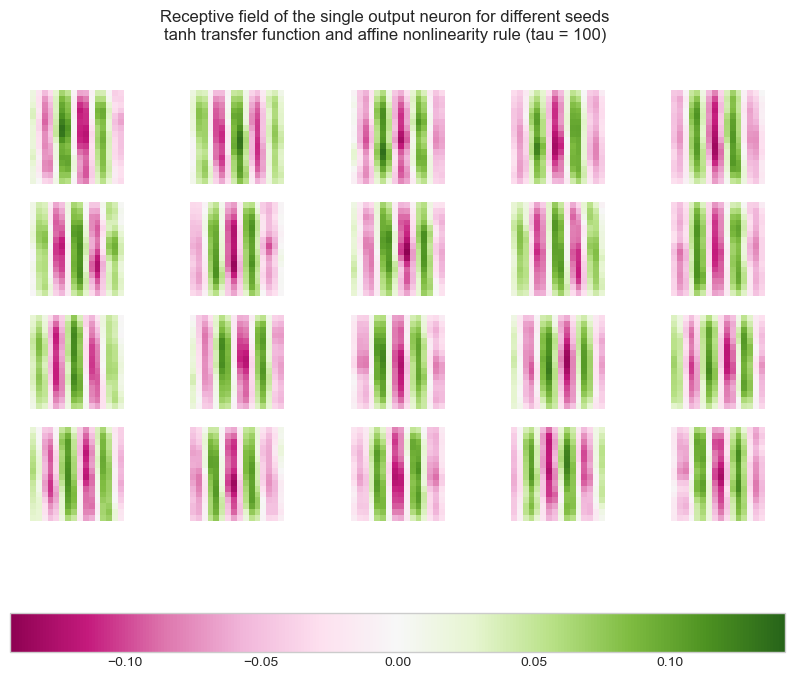

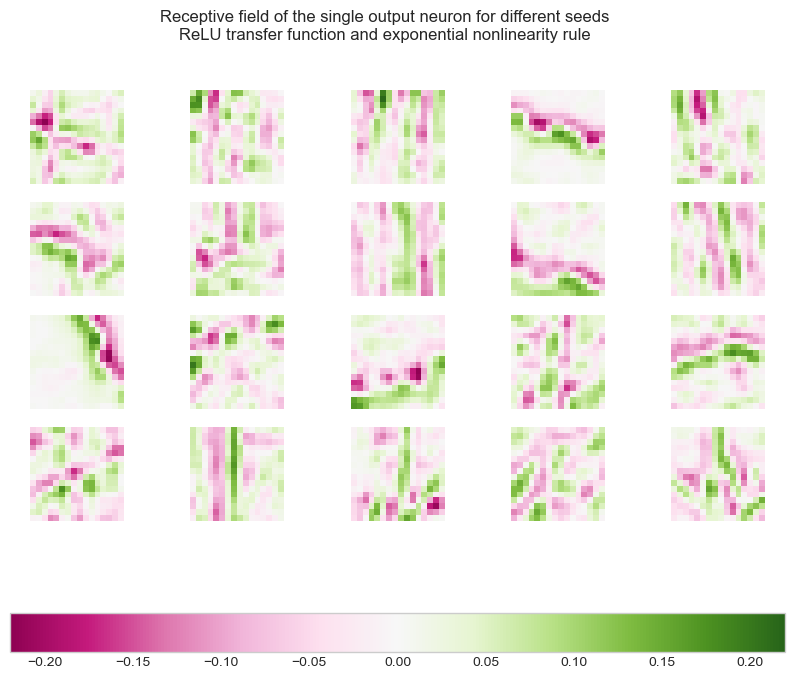

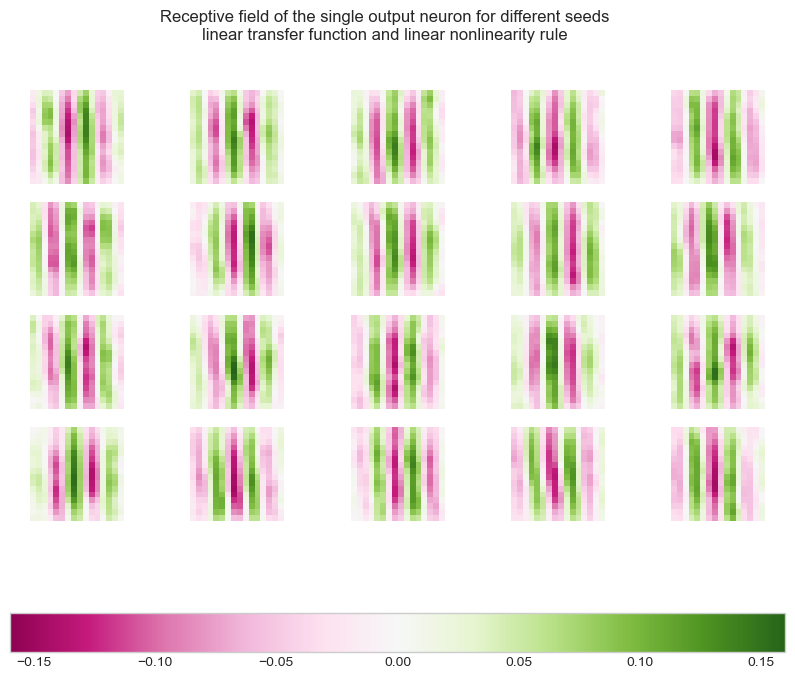

In [12]:
n_iter = int(150e3)
gamma = 1e-4
n_trials = 20
seeds = range(n_trials)


rfs_1 = []
rfs_2 = []
rfs_3 = []
for seed in tqdm(seeds, desc="Training networks with different seeds"):
    
    net_nonlin1 = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
        transfer_function=transfer_func_1,
        rule_non_linearity=nonlinearity_1,
    )
    theta_1 = np.ones((1,))
    utils.train_network(
        net=net_nonlin1,
        patches=patches,
        n_iter=n_iter,
        theta=theta_1,
        gamma=gamma,
        seed=seed,
        tau=100,
    )    
    rfs_1.append(net_nonlin1.weights)
    
    net_nonlin2 = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
        transfer_function=transfer_func_2,
        rule_non_linearity=nonlinearity_2,
    )
    utils.train_network(
        net=net_nonlin2,
        patches=patches,
        n_iter=n_iter,
        theta=None,
        gamma=gamma,
        seed=seed,
        tau=None,
    )
    rfs_2.append(net_nonlin2.weights)
    
    
    net_linear = network.Visual_network(
        n_in = 16*16,
        n_out = 1,
        seed=seed,
        transfer_function=linear_transfer_func,
        rule_non_linearity=linear_nonlinearity,
    )
    utils.train_network(
        net=net_linear,
        patches=patches,
        n_iter=n_iter,
        theta=None,
        gamma=gamma,
        seed=seed,
        tau=None,
    )
    rfs_3.append(net_linear.weights)
    
    
utils.show_RFs(rfs_1, n_col=5, patch_size=16, title="Receptive field of the single output neuron for different seeds\n"
                                                    "tanh transfer function and affine nonlinearity rule (tau = 100)")
utils.show_RFs(rfs_2, n_col=5, patch_size=16, title="Receptive field of the single output neuron for different seeds\n"
                                                    "ReLU transfer function and exponential nonlinearity rule")
    
utils.show_RFs(rfs_3, n_col=5, patch_size=16, title="Receptive field of the single output neuron for different seeds\n"
                                                    "linear transfer function and linear nonlinearity rule")

#### Answer:
We basically fall back to “plain” Hebb.
Every seed ends up with almost the same RF: a strong vertical bar, only phase or contrast changes a bit; there are no diagonals, no curves, almost no positional scatter.
This happens because with a linear rule there is only potentiation, never depression, so the weight vector keeps growing along the direction of highest input variance: mathematically that is the first principal component of the image-patch covariance and in the given natural images that PC looks like a vertical stripe;
Because all seeds “see” the same dominant variance direction, they all converge to it making the diversity negligible.

### 1.11
#### Answer: 
Oja rule implements normalization directly in the update by subtracting the weights with the post activation squared.

### 1.12

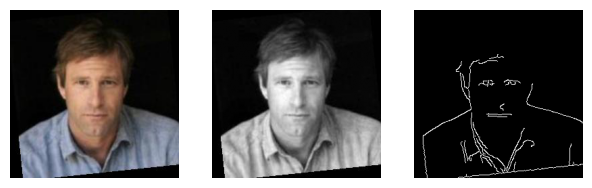

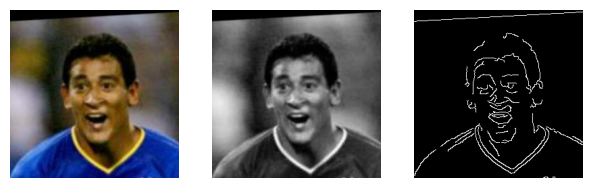

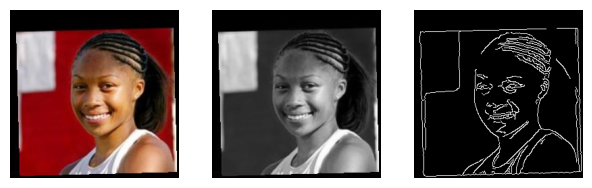

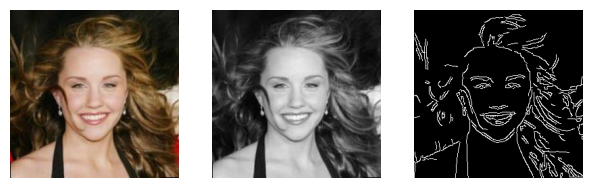

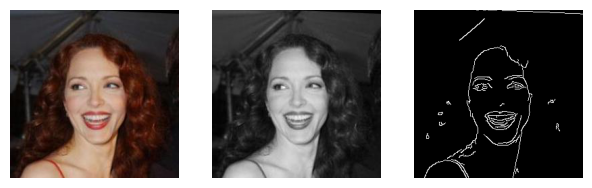

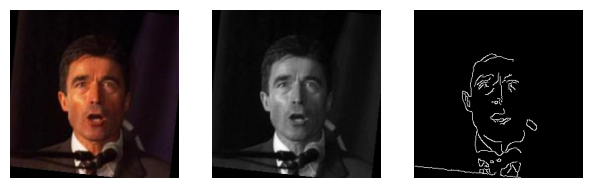

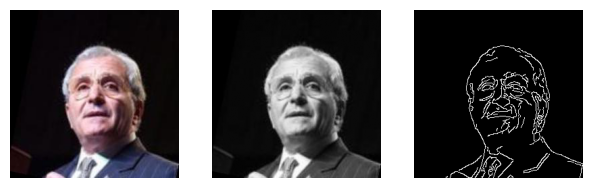

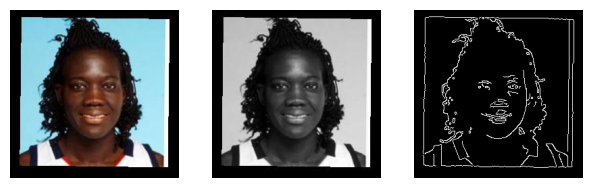

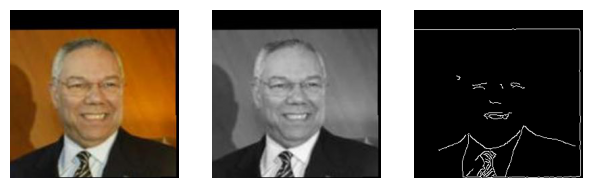

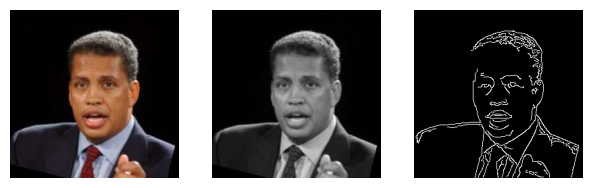

In [13]:
ext = '.jpg'
path = 'custom_images/'

custom_patch_list = []
custom_edges_patch_list = []
for filename in os.listdir(path):
    if filename.endswith(ext):
        
        plt.figure(figsize=(10, 5))
        
        
        img = Image.open(os.path.join(path, filename))
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.axis('off')
        
        
        img = img.convert('L')
        plt.subplot(1, 4, 2)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        edges_img = cv2.Canny(np.array(img).astype(np.uint8), 100, 200)
        plt.subplot(1, 4, 3)
        plt.imshow(edges_img, cmap='gray')
        plt.axis('off')
        
        normalized_img = utils.normalize(img)
        edges_img = utils.normalize(edges_img)
        
        patches_normalized = utils.extract_patches(normalized_img, verbose=False)
        patches_edge_extracted = utils.extract_patches(edges_img, verbose=False)
        
        custom_patch_list.extend(patches_normalized)
        custom_edges_patch_list.extend(patches_edge_extracted)
        
        

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

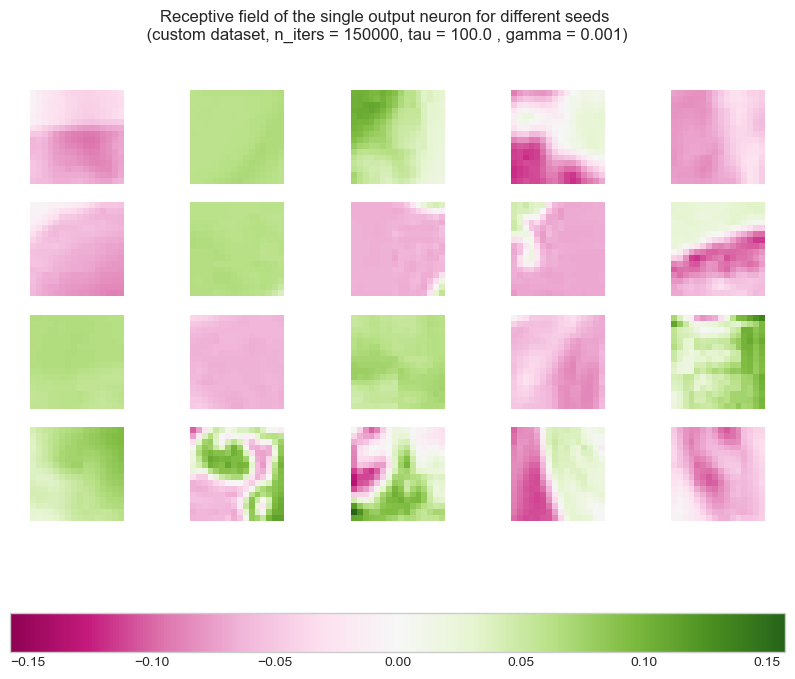

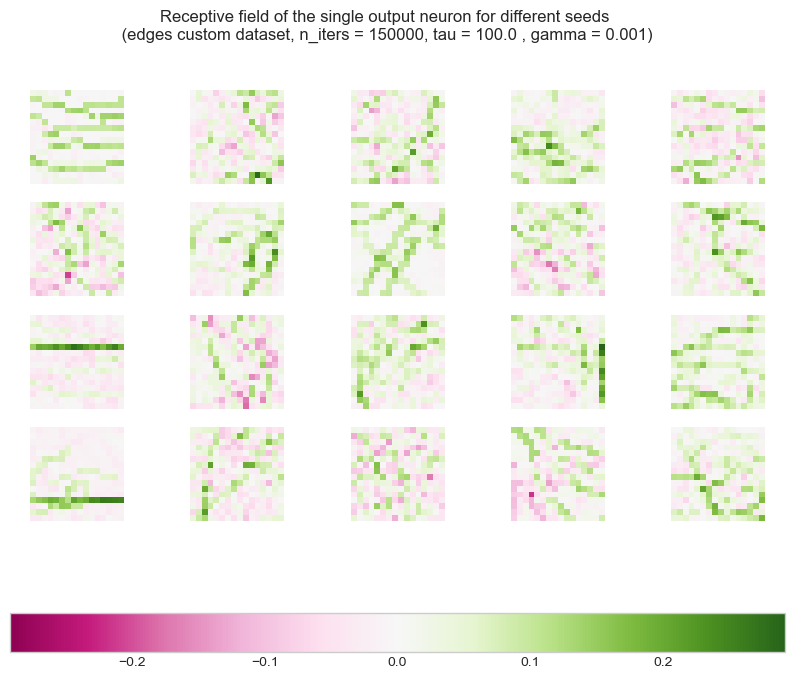

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

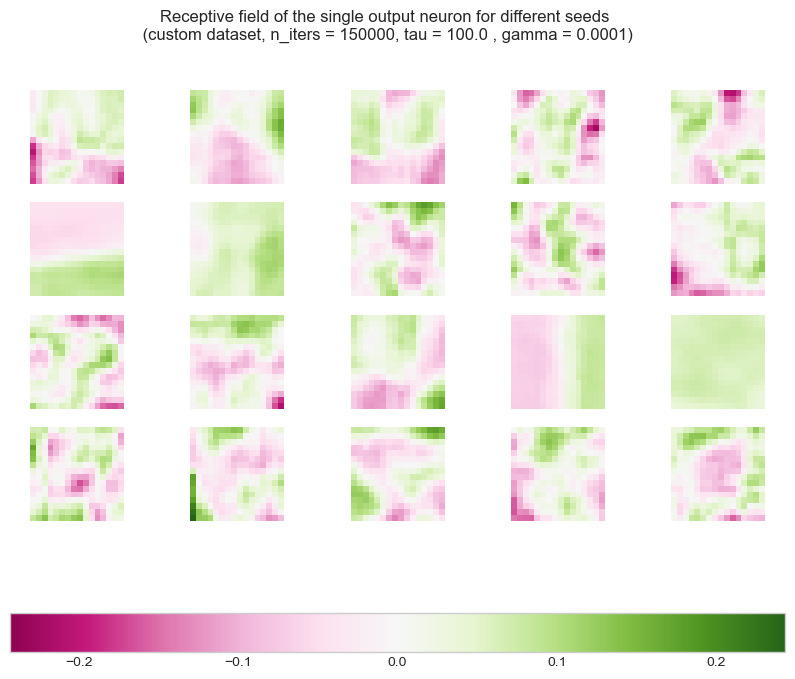

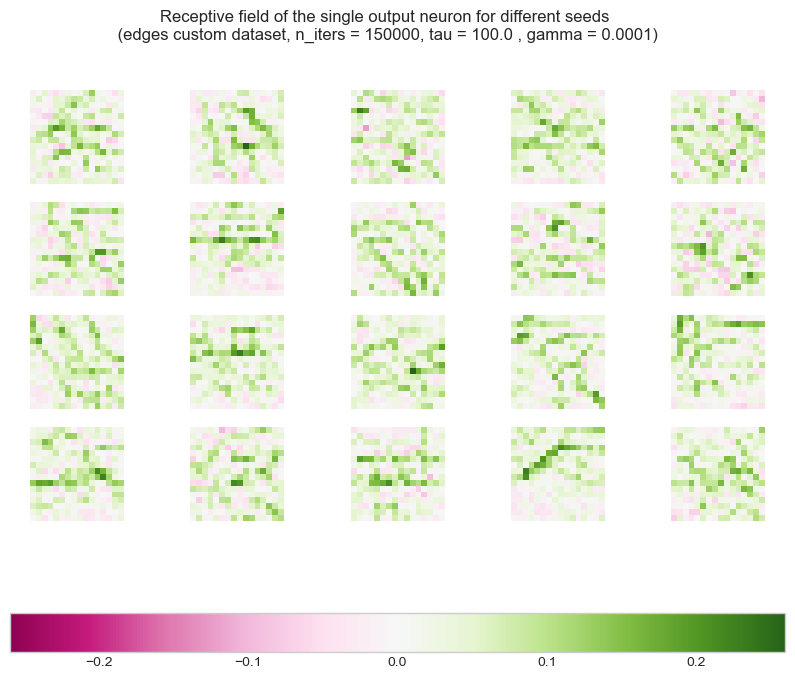

Training networks with different seeds:   0%|          | 0/20 [00:00<?, ?it/s]

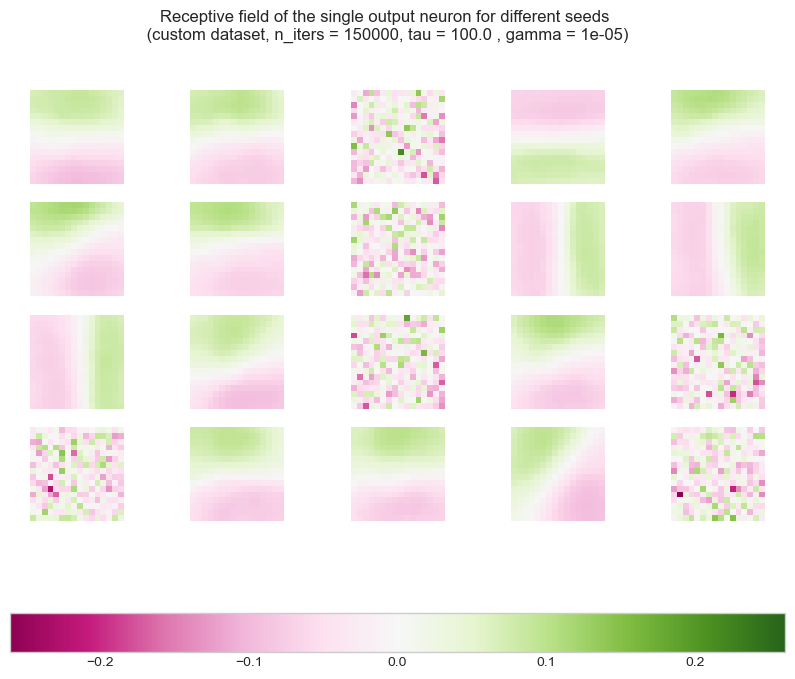

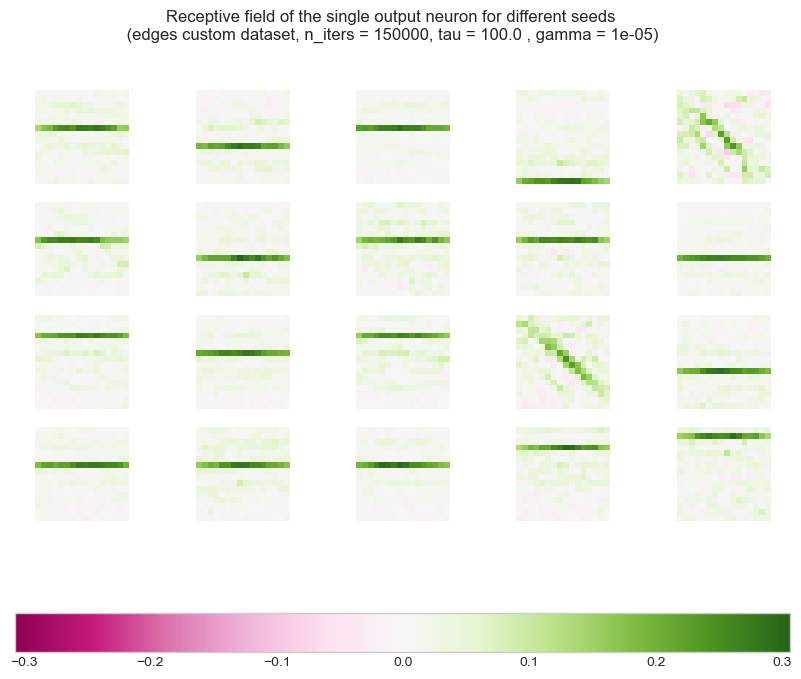

In [14]:
n_iter = int(150e3)
n_trials = 20
tau = 1e2
seeds = range(n_trials)
gammas = [1e-3, 1e-4, 1e-5]

for gamma in gammas:
    rfs_custom_normlaiezd = []
    rfs_custom_edges = []
    for seed in tqdm(seeds, desc="Training networks with different seeds"):
        
        net = network.Visual_network(
            n_in = 16*16,
            n_out = 1,
            seed=seed,
        )
        theta = np.zeros((1,))
        utils.train_network(
            net=net,
            patches=custom_patch_list,
            theta=theta,
            n_iter=n_iter,
            gamma=gamma,
            seed=seed,
            tau=tau,
        )
        rfs_custom_normlaiezd.append(net.weights)
        
        
        net = network.Visual_network(
            n_in = 16*16,
            n_out = 1,
            seed=seed,
        )
        theta = np.zeros((1,))
        utils.train_network(
            net=net,
            patches=custom_edges_patch_list,
            theta=theta,
            n_iter=n_iter,
            gamma=gamma,
            seed=seed,
            tau=tau,
        )
        rfs_custom_edges.append(net.weights)
        
        
    utils.show_RFs(rfs_custom_normlaiezd, n_col=5, patch_size=16, title=f"Receptive field of the single output neuron for different seeds\n (custom dataset, n_iters = {n_iter}, tau = {tau} , gamma = {gamma})")
    utils.show_RFs(rfs_custom_edges, n_col=5, patch_size=16, title=f"Receptive field of the single output neuron for different seeds\n (edges custom dataset, n_iters = {n_iter}, tau = {tau} , gamma = {gamma})")
        

#### Answer:

Yes, the new RFs look quite different.
The Hebbian rule is still picking out directions of largest variance in the input.  
If the patch collection changes, those directions change:

* natural scenes -> vertical edges dominate -> vertical bars;  
* face edges -> horizontal contours dominate -> horizontal bars;  
* raw faces -> coarse light/dark blobs dominate -> smooth gradients or centre–surround patterns.

It's interesting to note that one set of the shown RFs is particularly Gabor-like: each receptive field is split into two broad regions of opposite sign (green vs magenta )and the transition between the two is smooth and oriented (horizontal, vertical, or diagonal);
That’s exactly what a very low-frequency Gabor looks like: a single bright lobe next to a dark lobe under a Gaussian envelope.

What we don’t see instead are higher-frequency Gabors with multiple cycles; faces simply don’t provide those fine stripes. The network is therefore learning “one-cycle” Gabors whose wavelength spans almost the whole $16 × 16$ patch.


